In [1]:
import minimal_pytorch_rasterizer as mpr
import numpy as np
import torch
from torch import nn
import pickle, json
import cv2
from copy import deepcopy
import math
import nvdiffrast.torch as dr
import matplotlib.pyplot as plt

In [2]:
dtype = torch.float32
device = torch.device('cuda:0')

# Set cube object

In [3]:
def get_object(dtype, device):
    vertices = torch.tensor([
            [0, 0, 0], [1, 0, 0], [1, 1, 0], [0, 1, 0],
            [0, 1, 1], [1, 1, 1], [1, 0, 1], [0, 0, 1]
        ], dtype=dtype, device=device)

    faces = torch.tensor([
            [0, 2, 1], [0, 3, 2], [2, 3, 4], [2, 4, 5], [1, 2, 5], [1, 5, 6],
            [0, 7, 4], [0, 4, 3], [5, 4, 7], [5, 7, 6], [0, 6, 7], [0, 1, 6]
        ], dtype=torch.int32, device=device)

    R = torch.tensor(cv2.Rodrigues(np.array([0.5, 0.8, 0.2]))[0], dtype=dtype, device=device)
    t = torch.tensor([-0.5, -0.5, 1.3], dtype=dtype, device=device)
    vertices = vertices @ R.T + t
    
    return vertices, faces

# Set pinhole cam params

In [4]:
K = np.array([
    [250, 0, 160],
    [0, 200, 120],
    [0, 0, 1]
], dtype=np.float32)
w = 320
h = 240

near = 0.01
far = 100

fx, fy = K[0, 0], K[1, 1]
cx, cy = K[0, 2], K[1, 2]

# Get nvdiffrast result

In [5]:
glctx = dr.RasterizeGLContext()

In [6]:
vertices, faces = get_object(dtype, device)

matrix_ndc = torch.tensor([
    [2 * fx / w, 0.0, (w - 2 * cx) / w, 0],
    [0, 2 * fy / h, (h - 2 * cy) / h, 0],
    [0, 0, (far + near) / (near - far), 2 * far * near / (near - far)],
    [0, 0, -1, 0]
], device=device, dtype=dtype)

verts_3d_homo = torch.cat([vertices, torch.ones(len(vertices), 1, device=device)], dim=-1)
verts_3d_homo[:, 2] *= -1  # invert z-axis

verts_ndc = torch.matmul(verts_3d_homo, matrix_ndc.transpose(0, 1))

verts_ndc = torch.unsqueeze(verts_ndc, dim=0)

rast, rast_db = dr.rasterize(glctx, verts_ndc, faces, resolution=[h, w])

render, render_da = dr.interpolate(vertices[:, [2]], rast, faces, rast_db=rast_db, diff_attrs='all')

render_cpu = render[0, ..., 0].detach().cpu().numpy()
render_cpu[np.isinf(render_cpu)] = 0

nvdiffrast_depth = render_cpu
nvdiffrast_barycentric_weights = rast[0, ..., [0, 1]].detach().cpu().numpy()

# Get minimal_pytorch_rasterizer result

In [7]:
vertices, faces = get_object(dtype, device)

pinhole2d = mpr.Pinhole2D(
    fx=fx, fy=fy,
    cx=cx, cy=cy,
    w=w, h=h,
)

z_buffer = mpr.project_mesh(
    vertices=vertices,
    faces=faces,
    vertice_values=vertices[:, [2]],  # take z coordinate as values
    pinhole=pinhole2d
)

minimal_pytorch_rasterizer_depth = z_buffer[..., 0].detach().cpu().numpy()

# Compare depth

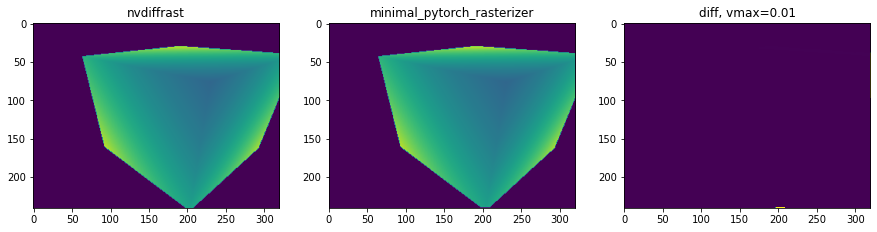

In [8]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(nvdiffrast_depth, vmin=0, vmax=2)
axs[0].set_title('nvdiffrast')
axs[1].imshow(minimal_pytorch_rasterizer_depth, vmin=0, vmax=2)
axs[1].set_title('minimal_pytorch_rasterizer')
axs[2].imshow(np.abs(nvdiffrast_depth - minimal_pytorch_rasterizer_depth), vmin=0, vmax=.01)
axs[2].set_title('diff, vmax=0.01')
plt.show()

# Compare barycentric coordinates

minimal_pytorch_rasterizer does not prodive an explicit barycentric coordinates output.

Below is an imitation of what happens in rasterizer_kernel.cu

In [9]:
def cpu_render(
    vertices, faces,
    fx, fy, cx, cy, h, w
):
    
    result = np.ones((h, w), dtype=np.float32) * 1e6
    
    weights = np.zeros((h, w, 3), dtype=np.float32)
    
    n = len(vertices)
    m = len(faces)
    
    xs = np.zeros(n, dtype=np.float32)
    ys = np.zeros(n, dtype=np.float32)
    zs = np.zeros(n, dtype=np.float32)
    for i in range(n):
        z = vertices[i][2]
        z_inv = 1. / z;
        xs[i] = vertices[i][0] * z_inv * fx + cx;
        xs[i] = 2 * xs[i] / w - 1;
        ys[i] = vertices[i][1] * z_inv * fy + cy;
        ys[i] = 2 * ys[i] / h - 1;
        zs[i] = z;
            
    face_ndc = np.zeros(9, dtype=np.float32)
    face_ndc_inv = np.zeros(9, dtype=np.float32)
    
    for face_i in range(m):
        ai = faces[face_i][0];
        bi = faces[face_i][1];
        ci = faces[face_i][2];
        
        face_ndc[0] = xs[ai]; face_ndc[1] = ys[ai]; face_ndc[2] = zs[ai];
        face_ndc[3] = xs[bi]; face_ndc[4] = ys[bi]; face_ndc[5] = zs[bi];
        face_ndc[6] = xs[ci]; face_ndc[7] = ys[ci]; face_ndc[8] = zs[ci];
    
        face_ndc_inv[0] = face_ndc[4] - face_ndc[7];
        face_ndc_inv[1] = face_ndc[6] - face_ndc[3];
        face_ndc_inv[2] = face_ndc[3] * face_ndc[7] - face_ndc[6] * face_ndc[4];
        face_ndc_inv[3] = face_ndc[7] - face_ndc[1];
        face_ndc_inv[4] = face_ndc[0] - face_ndc[6];
        face_ndc_inv[5] = face_ndc[6] * face_ndc[1] - face_ndc[0] * face_ndc[7];
        face_ndc_inv[6] = face_ndc[1] - face_ndc[4];
        face_ndc_inv[7] = face_ndc[3] - face_ndc[0];
        face_ndc_inv[8] = face_ndc[0] * face_ndc[4] - face_ndc[3] * face_ndc[1];

        denom = (
            face_ndc[6] * (face_ndc[1] - face_ndc[4]) +
            face_ndc[0] * (face_ndc[4] - face_ndc[7]) +
            face_ndc[3] * (face_ndc[7] - face_ndc[1])
        );
        
        face_ndc_inv /= denom;
        
        min_x = min(min(face_ndc[0], face_ndc[3]), face_ndc[6]);
        min_x = (min_x + 1) / 2 * w + 0.5;  # convert from [-1, 1] to [0, W]
        min_xi = int(math.floor(min_x));
        min_xi = min(max(min_xi, 0), w - 1);
        max_x = max(max(face_ndc[0], face_ndc[3]), face_ndc[6]);
        max_x = (max_x + 1) / 2 * w + 0.5;
        max_xi = int(math.ceil(max_x));
        max_xi = min(max(max_xi, 0), w - 1);

        min_y = min(min(face_ndc[1], face_ndc[4]), face_ndc[7]);
        min_y = (min_y + 1) / 2 * h + 0.5;
        min_yi = int(math.floor(min_y));
        min_yi = min(max(min_yi, 0), h - 1);
        max_y = max(max(face_ndc[1], face_ndc[4]), face_ndc[7]);
        max_y = (max_y + 1) / 2 * h + 0.5;
        max_yi = int(math.ceil(max_y));
        max_yi = min(max(max_yi, 0), h - 1);
        
        top, bottom = min_yi, max_yi;
        left, right = min_xi, max_xi;
        
        def calc_bary(x, y):
            if (((y - face_ndc[1]) * (face_ndc[3] - face_ndc[0]) > (x - face_ndc[0]) * (face_ndc[4] - face_ndc[1])) or
                ((y - face_ndc[4]) * (face_ndc[6] - face_ndc[3]) > (x - face_ndc[3]) * (face_ndc[7] - face_ndc[4])) or
                ((y - face_ndc[7]) * (face_ndc[0] - face_ndc[6]) > (x - face_ndc[6]) * (face_ndc[1] - face_ndc[7]))):
                return None
            
            wa = face_ndc_inv[0] * x + face_ndc_inv[1] * y + face_ndc_inv[2];
            wb = face_ndc_inv[3] * x + face_ndc_inv[4] * y + face_ndc_inv[5];
            wc = face_ndc_inv[6] * x + face_ndc_inv[7] * y + face_ndc_inv[8];
            
            wsum = wa + wb + wc;
            wa /= wsum; wb /= wsum; wc /= wsum;
            
            wa /= face_ndc[2];
            wb /= face_ndc[5];
            wc /= face_ndc[8];
            
            wsum = wa + wb + wc;
            wa /= wsum; wb /= wsum; wc /= wsum;
            
            return wa, wb, wc    
            
        
        for i in range(top, bottom):
            for j in range(left, right):
                x = (j + 0.5) / w * 2 - 1;
                y = (i + 0.5) / h * 2 - 1;

                bary = calc_bary(x, y)
                if bary is None:
                    continue
                
                wa, wb, wc = bary
            
                face_z = wa * face_ndc[2] + wb * face_ndc[5] + wc * face_ndc[8];
                
                if face_z < result[i][j]:
                    result[i][j] = face_z
                    weights[i, j, 0] = wa
                    weights[i, j, 1] = wb
                    weights[i, j, 2] = wc
                    
    return result, weights

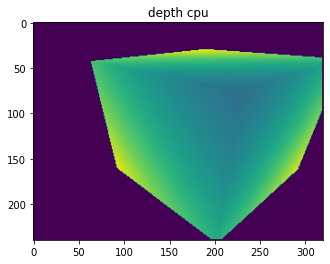

In [10]:
vertices, faces = get_object(dtype, device)

cpu_depth, cpu_weights = cpu_render(
    vertices.detach().cpu().numpy(), faces.detach().cpu().numpy(), 
    fx=fx, fy=fy,
    cx=cx, cy=cy,
    w=w, h=h
)
cpu_depth[cpu_depth > 1e3] = 0

plt.imshow(cpu_depth)
plt.title('depth cpu')
plt.show()

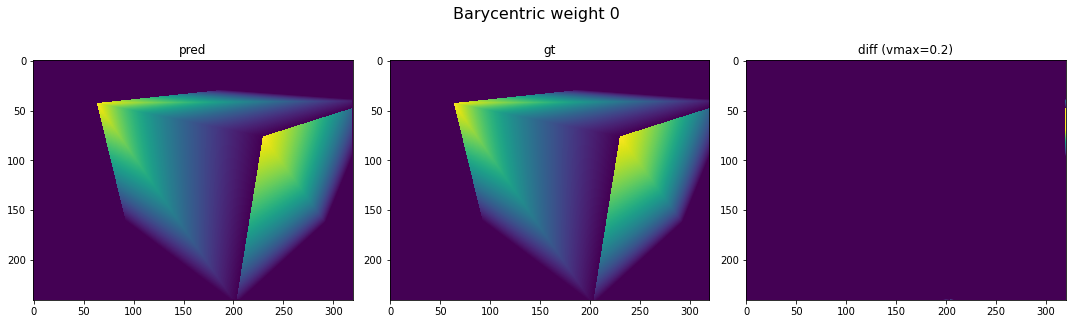

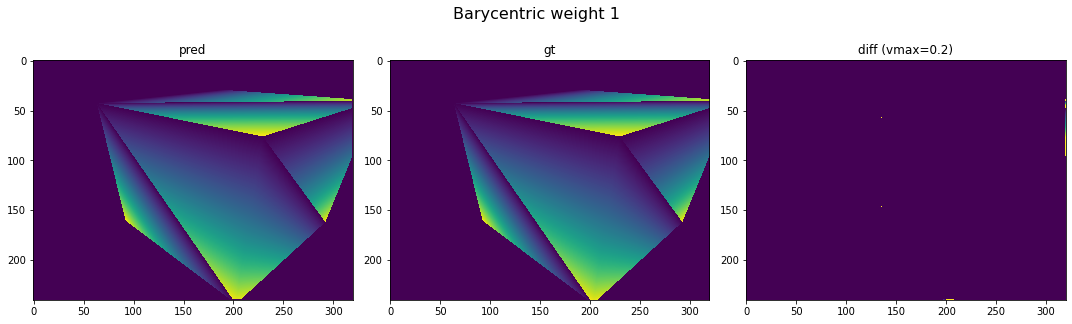

In [11]:
for i in range(2):
    gt = nvdiffrast_barycentric_weights[..., i]
    pred = cpu_weights[..., i]
    diff = np.abs(pred - gt)
    
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    axs[0].imshow(pred, vmin=0, vmax=1)
    axs[0].title.set_text('pred')
    axs[1].imshow(gt, vmin=0, vmax=1)
    axs[1].title.set_text('gt')
    axs[2].imshow(diff, vmin=0, vmax=.2)
    axs[2].title.set_text('diff (vmax=0.2)')
    fig.suptitle(f'Barycentric weight {i}', fontsize=16)
    plt.tight_layout()
    plt.show()
    
    print('\n' * 2)